## Dog Breed Prediction
source: https://www.kaggle.com/datasets/catherinehorng/dogbreedidfromcomp

In [1]:
# Important library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# tqdm is a library in Python that provides a fast, extensible progress bar for
# loops and other iterable processes. When you use from tqdm import tqdm,
# you are importing the tqdm class, which you can then use to wrap an iterable
# and create a progress bar for it. This can be particularly useful when you have
# long-running tasks or loops, as it gives you a visual indication of the progres
from tqdm import tqdm
from keras.preprocessing import image
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, AveragePooling2D
from keras.optimizers import Adam

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
dog_breed_path = '../input/dogbreedidfromcomp/labels.csv'

In [3]:
# Read the labels.csv file and checking shape and records
labels_all = pd.read_csv(dog_breed_path)
print(labels_all.shape)
labels_all.head()

(10222, 2)


,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [4]:
len(labels_all['breed'].unique())

120

In [5]:
# Visualize the number of each breeds
breeds_all = labels_all["breed"]
breed_counts = breeds_all.value_counts()
breed_counts

breed
scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
brabancon_griffon        67
komondor                 67
eskimo_dog               66
briard                   66
Name: count, Length: 120, dtype: int64

Here we are finding out the count per class i.e. total data in each class using value_counts() function.

In [6]:
# # Selecting first 3 breeds (Limitation due to computation power)
CLASS_NAMES =  np.random.choice(labels_all['breed'].unique(), size=50, replace=False)
labels = labels_all[(labels_all['breed'].isin(CLASS_NAMES))]
labels = labels.reset_index()
labels

,index,id,breed
0,0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,2,001cdf01b096e06d78e9e5112d419397,pekinese
2,7,002a283a315af96eaea0e28e7163b21b,borzoi
3,9,0042188c895a2f14ef64a918ed9c7b64,scottish_deerhound
4,11,0067dc3eab0b3c3ef0439477624d85d6,walker_hound
...,...,...,...
4283,10199,ff7334b06cee8667a7f30eb00e0b93cf,whippet
4284,10206,ffa16727a9ee462ee3f386be865b199e,irish_wolfhound
4285,10216,ffcffab7e4beef9a9b8076ef2ca51909,samoyed
4286,10217,ffd25009d635cfd16e793503ac5edef0,borzoi


In [33]:
len(labels['breed'].unique())

50

In [34]:
len(CLASS_NAMES)

50

In [7]:
# Creating numpy matrix with zeros
X_data = np.zeros((len(labels), 224, 224, 3), dtype='float32')
# One hot encoding
Y_data = label_binarize(labels['breed'], classes = CLASS_NAMES)

# Reading and converting image to numpy array and normalizing dataset
for i in tqdm(range(len(labels))):

    # target_size=(224, 224): resizes the image to a standard size of 224x224 pixels.
    # %s for keep 'labels['id'][i]' as string format
    # For example  labels['id'][i] holds the value '00123', the resulting path becomes:
    #         'dog_dataset/train/00123.jpg'
    img = image.load_img('../input/dogbreedidfromcomp/train/%s.jpg' % labels['id'][i], target_size=(224, 224))
    img = image.img_to_array(img)

    x = np.expand_dims(img.copy(), axis=0)
    # Normalizing pixel values  to avoid the possibility of exploding gradients
    # because of the high range of the pixels [0, 255], and improve the convergence speed.
    X_data[i] = x / 255.0

# Printing train image and one hot encode shape & size
print('\nTrain Images shape: ',X_data.shape,' size: {:,}'.format(X_data.size))
print('One-hot encoded output shape: ',Y_data.shape,' size: {:,}'.format(Y_data.size))

100%|██████████| 4288/4288 [00:29<00:00, 144.41it/s]


Train Images shape:  (4288, 224, 224, 3)  size: 645,464,064
One-hot encoded output shape:  (4288, 50)  size: 214,400


In [8]:
Y_data = label_binarize(labels['breed'], classes = list(labels['breed'].unique()))
print('One-hot encoded output shape: ',Y_data.shape,' size: {:,}'.format(Y_data.size))

One-hot encoded output shape:  (4288, 50)  size: 214,400


In [9]:
# Splitting the data set into training and testing data sets
X_train_and_val, X_test, Y_train_and_val, Y_test = train_test_split(X_data, Y_data, test_size = 0.1)
# Splitting the training data set into training and validation data sets
X_train, X_val, Y_train, Y_val = train_test_split(X_train_and_val, Y_train_and_val, test_size = 0.2)

From normal architech of convolutional neuron network (CNNs) will chance to vanishing and exploding gradient problem (When add #layer until certain point. The performance will increasing then after certain point will going to decrease the performance) when CNNs get more deeper. So I will try to use MobileNetV2 Architecture for reduce that problem.

- Modified by Somchai.K

In [42]:
from keras.applications import MobileNetV2
from keras import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam

# Load pre-trained MobileNetV2 model
# include_top: whether to include the 3 fully-connected layers at the top of the network.
base_model = MobileNetV2(
    weights='imagenet', 
    include_top=True, 
    input_shape=(224, 224, 3), 
    pooling='max',
    classifier_activation="softmax"
)

# Freeze the convolutional layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the MobileNetV2 base
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(724, activation='relu'))
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(Y_data.shape[1], activation='softmax'))  # Adjust the number of classes based on your dataset

# Compile the model
model.compile(loss = 'categorical_crossentropy', optimizer = Adam(0.0001),metrics=['accuracy'])

model.summary()

14536120/14536120 [==============================] - 0s 0us/step
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 1000)              3538984   
 tional)                                                         
                                                                 
 flatten_16 (Flatten)        (None, 1000)              0         
                                                                 
 dense_119 (Dense)           (None, 724)               724724    
                                                                 
 dense_120 (Dense)           (None, 512)               371200    
                                                                 
 dense_121 (Dense)           (None, 256)               131328    
                                                                 
 dense_122 (Dense)           (None, 256)              

In [43]:
# Training the model
epochs = 70
batch_size = 192

history = model.fit(X_train, Y_train, batch_size = batch_size, epochs = epochs,
                    validation_data = (X_val, Y_val))

Epoch 1/70
17/17 [==============================] - 11s 353ms/step - loss: 3.9057 - accuracy: 0.1205 - val_loss: 3.8976 - val_accuracy: 0.2215
Epoch 2/70
17/17 [==============================] - 3s 201ms/step - loss: 3.8873 - accuracy: 0.2919 - val_loss: 3.8740 - val_accuracy: 0.2966
Epoch 3/70
17/17 [==============================] - 3s 203ms/step - loss: 3.8525 - accuracy: 0.3252 - val_loss: 3.8267 - val_accuracy: 0.2824
Epoch 4/70
17/17 [==============================] - 3s 202ms/step - loss: 3.7832 - accuracy: 0.3074 - val_loss: 3.7320 - val_accuracy: 0.3018
Epoch 5/70
17/17 [==============================] - 3s 201ms/step - loss: 3.6493 - accuracy: 0.3278 - val_loss: 3.5615 - val_accuracy: 0.3161
Epoch 6/70
17/17 [==============================] - 3s 202ms/step - loss: 3.4188 - accuracy: 0.3605 - val_loss: 3.2871 - val_accuracy: 0.3290
Epoch 7/70
17/17 [==============================] - 3s 203ms/step - loss: 3.0762 - accuracy: 0.4227 - val_loss: 2.9327 - val_accuracy: 0.4339
Epoch

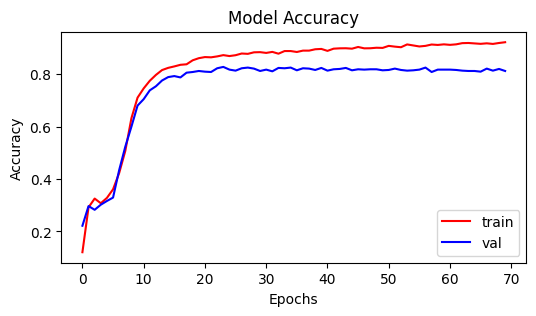

In [44]:
# Plot the training history
plt.figure(figsize=(6, 3))
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

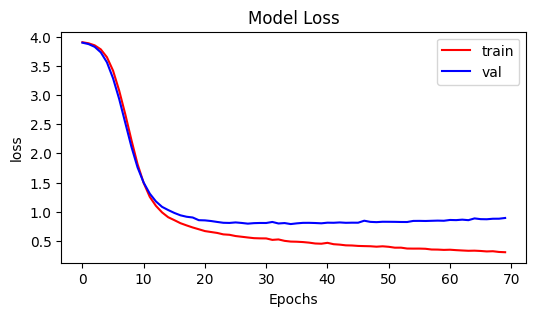

In [45]:
# Plot the training history
plt.figure(figsize=(6, 3))
plt.plot(history.history['loss'], color='r')
plt.plot(history.history['val_loss'], color='b')
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.legend(['train', 'val'])

plt.show()

In [46]:
Y_pred = model.predict(X_test)
score = model.evaluate(X_test, Y_test)
print('Accuracy over the test set: \n ', round((score[1]*100), 2), '%')

14/14 [==============================] - 0s 30ms/step - loss: 0.9157 - accuracy: 0.8438
Accuracy over the test set: 
  84.38 %


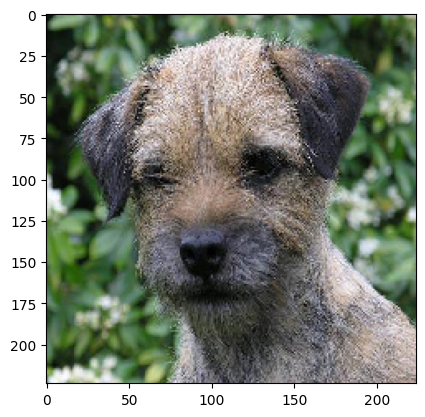

Originally :  boston_bull
Predicted :  boston_bull


In [47]:
# Plotting image to compare
plt.imshow(X_test[1,:,:,:])
plt.show()

# Finding max value from predition list and comaparing original value vs predicted
print("Originally : ",labels['breed'][np.argmax(Y_test[1])])
print("Predicted : ",labels['breed'][np.argmax(Y_pred[1])])

### Save model

In [48]:
model.save('dog_breed.h5')

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
